<a href="https://colab.research.google.com/github/Shubbair/Face-Mask-Detection/blob/main/Training%26Testing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data From Kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pranavsingaraju/facemask-detection-dataset-20000-images

 99% 595M/604M [00:06<00:00, 130MB/s]
100% 604M/604M [00:06<00:00, 92.6MB/s]


In [ ]:
!unzip /content/facemask-detection-dataset-20000-images.zip -d facemask-dataset/

Streaming output truncated to the last 5000 lines.
  inflating: facemask-dataset/new_without_mask/seed5000.png  
  inflating: facemask-dataset/new_without_mask/seed5001.png  
  inflating: facemask-dataset/new_without_mask/seed5002.png  
  inflating: facemask-dataset/new_without_mask/seed5003.png  
  inflating: facemask-dataset/new_without_mask/seed5004.png  
  inflating: facemask-dataset/new_without_mask/seed5005.png  
  inflating: facemask-dataset/new_without_mask/seed5006.png  
  inflating: facemask-dataset/new_without_mask/seed5007.png  
  inflating: facemask-dataset/new_without_mask/seed5008.png  
  inflating: facemask-dataset/new_without_mask/seed5009.png  
  inflating: facemask-dataset/new_without_mask/seed5010.png  
  inflating: facemask-dataset/new_without_mask/seed5011.png  
  inflating: facemask-dataset/new_without_mask/seed5012.png  
  inflating: facemask-dataset/new_without_mask/seed5013.png  
  inflating: facemask-dataset/new_without_mask/seed5014.png  
  inflating: facema

# 1.Import Libraries

In [ ]:
import os
import cv2
import random
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

# 2.Read & Process Data

#### the dataset are grayscale resized images 

## 2.1 Plot 25 Images randomly

In [ ]:
os.listdir('/content/facemask-dataset/')

['new_without_mask', 'new_with_mask']

#### take random images from folder with_mask , without_mask

In [ ]:
total_images = []

mask_images_path = '/content/facemask-dataset/new_with_mask/'
without_mask_images_path = '/content/facemask-dataset/new_without_mask/'

with_mask = []
without_mask = []

with_mask = np.random.choice(os.listdir(mask_images_path),13) # random pick images size 13
with_mask = [mask_images_path + img for img in with_mask]     # join mask images with path

without_mask = np.random.choice(os.listdir(without_mask_images_path),12) # random pick images size 12
without_mask = [without_mask_images_path + img for img in without_mask]  # join images without mask with path

total_images.extend(with_mask)
total_images.extend(without_mask)

random.shuffle(total_images)    # shuffle the paths   

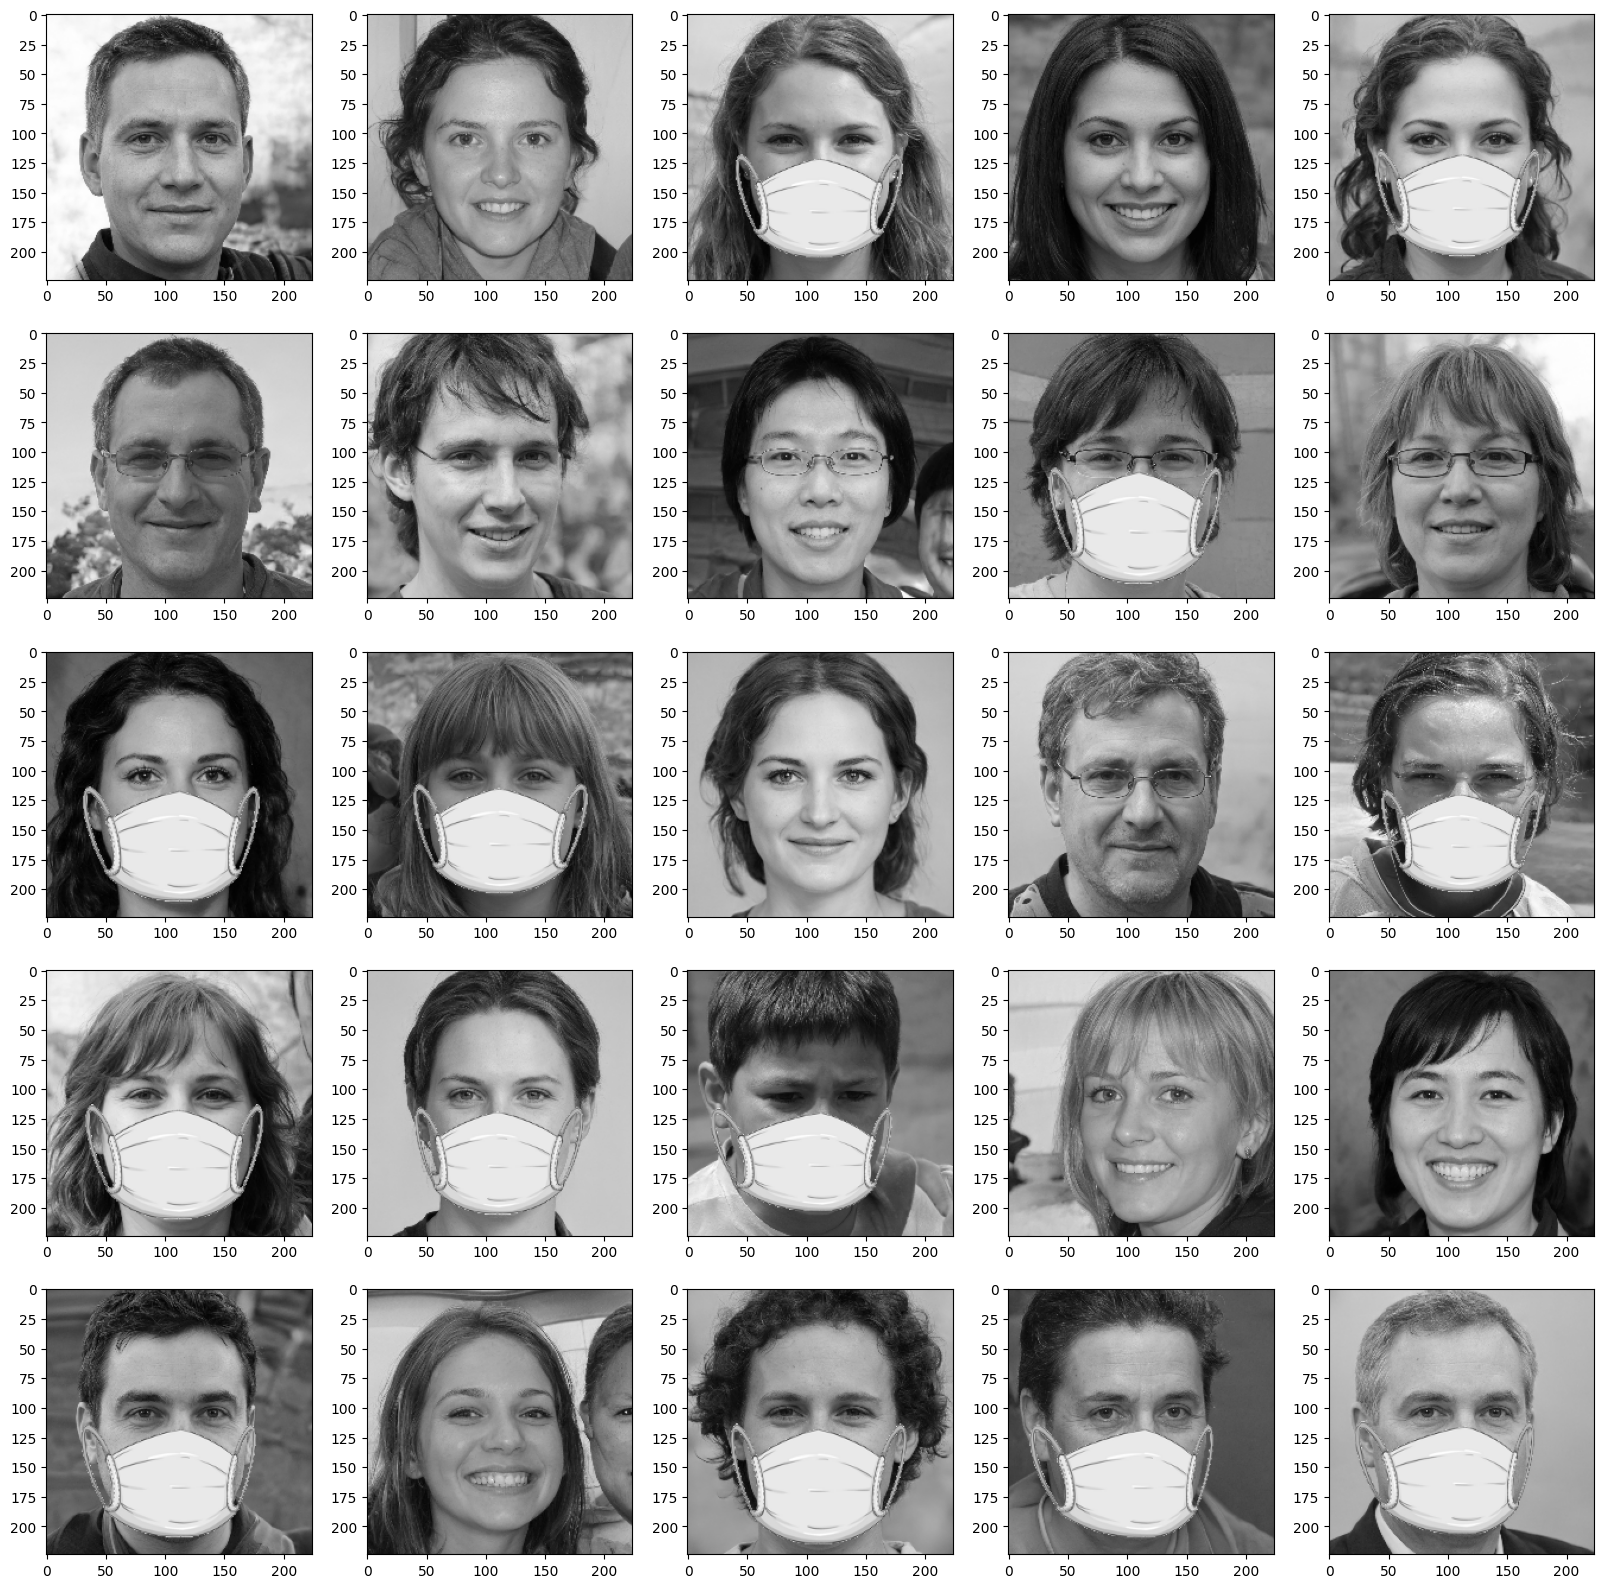

In [ ]:
plt.figure(figsize=(20, 20))
for idx in range(0,25):
    image = cv2.imread(total_images[idx])
    plt.subplot(5,5,idx+1)
    plt.imshow(image)
plt.show()

In [ ]:
TRAINING_DIR = "/content/facemask-dataset"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.,
    validation_split=0.25,  
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    class_mode='binary',
    color_mode = 'grayscale',
    subset = 'training',
    target_size=(150, 150),
    batch_size=128
    )

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    class_mode='binary',
    color_mode = 'grayscale',
    subset = 'validation',
    target_size=(150, 150),
    batch_size=128
)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# 4. Modeling

## 4.1 Model Architecture

In [ ]:
inputs = tf.keras.layers.Input(shape=(150,150,1))

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation=tf.nn.relu)(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units = 512, activation=tf.nn.relu)(x)

output = tf.keras.layers.Dense(units = 1, activation=tf.nn.sigmoid)(x)

model = tf.keras.Model(inputs,output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['acc']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0     

## 4.2 Model Training

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_generator, epochs=15, validation_data=validation_generator,callbacks=[early_stopping])

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/15
118/118 [==============================] - 69s 484ms/step - loss: 0.6425 - acc: 0.6152 - val_loss: 0.5701 - val_acc: 0.7356
Epoch 2/15
118/118 [==============================] - 62s 525ms/step - loss: 0.4291 - acc: 0.8345 - val_loss: 0.2882 - val_acc: 0.9094
Epoch 3/15
118/118 [==============================] - 62s 527ms/step - loss: 0.2473 - acc: 0.9165 - val_loss: 0.1839 - val_acc: 0.9460
Epoch 4/15
118/118 [==============================] - 62s 526ms/step - loss: 0.1621 - acc: 0.9487 - val_loss: 0.1372 - val_acc: 0.9558
Epoch 5/15
118/118 [==============================] - 55s 464ms/step - loss: 0.1180 - acc: 0.9654 - val_loss: 0.1018 - val_acc: 0.9670
Epoch 6/15
118/118 [==============================] - 54s 456ms/step - loss: 0.1071 - acc: 0.9660 - val_loss: 0.0949 - val_acc: 0.9688
Epoch 7/15
118/118 [==============================] - 61s 520ms/step - loss: 0.0892 - acc: 0.9722 - val_loss: 0.0814 - val_acc: 0.9736
Epoch 8/15
118/118 [==============================] - 6

## 4.3 Model Activity

--------------------------------------------------


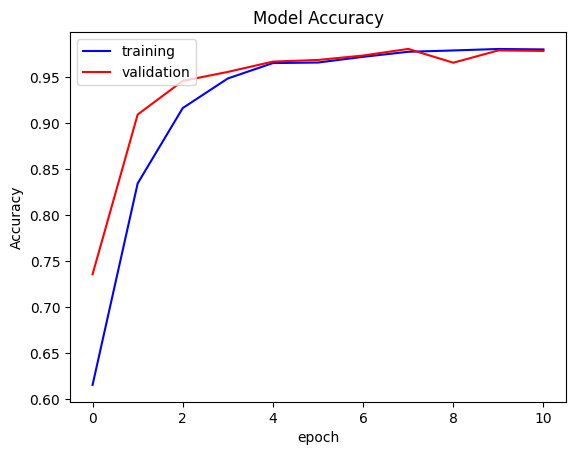

--------------------------------------------------


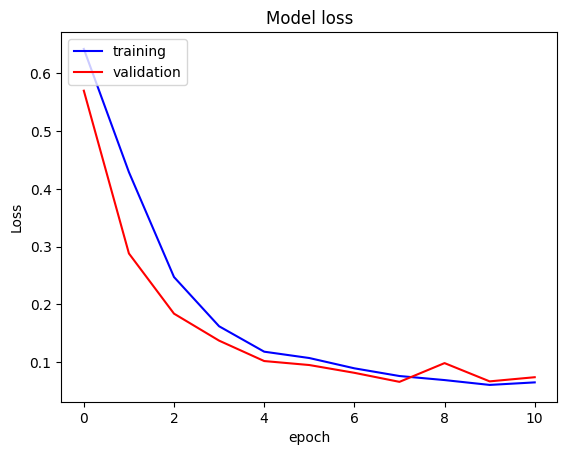

--------------------------------------------------


In [ ]:
# Accuracy
print('-'*50)

plt.plot(history.history['acc'],'b-')
plt.plot(history.history['val_acc'],'r-')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

print('-'*50)

# Loss
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'r-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

print('-'*50)

#### save model

In [ ]:
model.save('/content/facemask_detection.h5')

In [ ]:
from google.colab import files
files.download('facemask_detection.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>